# Прогнозирование большого количества рядов

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler as scaler
from itertools import product
import datetime

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
import warnings
warnings.simplefilter(action='ignore')

Загрузка данных

In [3]:
nonzero_reg=pd.read_csv("nonzero_regions.csv").iloc[:, 1]
nonzero_reg

0      1075
1      1076
2      1077
3      1125
4      1126
       ... 
97     2068
98     2069
99     2118
100    2119
101    2168
Name: 0, Length: 102, dtype: int64

In [4]:
df1 = pd.read_csv("taxi_01_2016.csv")
df2 = pd.read_csv("taxi_02_2016.csv")
df3 = pd.read_csv("taxi_03_2016.csv")
df4 = pd.read_csv("taxi_04_2016.csv")

data=pd.concat([df1, df2, df3, df4], axis = 0)

In [5]:
data.rename(columns = {'Unnamed: 0' : 'time'}, inplace = 1)
data.index = data.time
df = data.iloc[:, nonzero_reg]
df.head()

1075   1076  1077   1125   1126   1127   1128   1129  \
time                                                                        
2016-01-01 00:00:00  80.0  144.0  50.0   77.0  319.0  402.0  531.0  617.0   
2016-01-01 01:00:00  91.0  211.0  49.0  134.0  404.0  420.0  370.0  453.0   
2016-01-01 02:00:00  90.0  146.0  23.0  110.0  393.0  425.0  313.0  366.0   
2016-01-01 03:00:00  32.0   87.0  16.0   62.0  252.0  399.0  324.0  309.0   
2016-01-01 04:00:00  24.0   43.0  10.0   53.0  145.0  254.0  264.0  333.0   

                      1130   1131  ...  1630  1684  1733  1734  1783  2068  \
time                               ...                                       
2016-01-01 00:00:00  846.0  267.0  ...  12.0   0.0   2.0  44.0   5.0  41.0   
2016-01-01 01:00:00  594.0  224.0  ...  29.0   0.0   5.0   2.0   2.0   4.0   
2016-01-01 02:00:00  377.0  138.0  ...  47.0   0.0   3.0   0.0   4.0   0.0   
2016-01-01 03:00:00  327.0  166.0  ...  46.0   0.0   2.0   4.0   5.0   1.0   
2016-01-01 04:00:00  318.0  145.0  ...  43.0   0.0   0.0   1.0   1.0   0.0   

                     2069  2118  2119  2168  
time                                         
2016-01-01 00:00:00   4.0  70.0   7.0  66.0  
2016-01-01 01:00:00   0.0  47.0   1.0  29.0  
2016-01-01 02:00:00   0.0  69.0   1.0  14.0  
2016-01-01 03:00:00   0.0  21.0   0.0   9.0  
2016-01-01 04:00:00   0.0  26.0   1.0   6.0  

[5 rows x 102 columns]

In [6]:
reg_index=[int(x) for x in nonzero_reg]

Учитываем аномалии

In [7]:
wh_events = list({'2016-01-23', '2016-01-24'})
wheather = pd.to_datetime(pd.Series(wh_events))

Стандартизация столбцов

In [8]:
sc = scaler()
dfS = pd.DataFrame(sc.fit_transform(X = np.array(df)), columns = df.columns)
dfS

1075      1076      1077      1125      1126      1127      1128  \
0     0.534333  0.178299 -0.565388  0.271055  1.423610  0.941333  1.327688   
1     0.823393  1.005639 -0.582598  1.673853  2.292927  1.069294  0.407607   
2     0.797115  0.202995 -1.030077  1.083201  2.180427  1.104839  0.081865   
3    -0.727022 -0.525558 -1.150552 -0.098103  0.738384  0.920006  0.144727   
4    -0.937247 -1.068886 -1.253817 -0.319598 -0.355932 -0.110791 -0.198160   
...        ...       ...       ...       ...       ...       ...       ...   
2899  1.611740  0.980942  1.069631  0.861707  1.689519  1.247018  1.259110   
2900  1.243845  0.968594  0.277938  1.009370  1.127020  1.005314  1.396265   
2901  0.823393  0.314131  0.432834  1.206254  1.413383  1.374979  1.722008   
2902  1.059897 -0.402074  0.036988  0.837096  0.380430  1.076403  2.276342   
2903  0.849671 -0.142759 -0.341648  0.492549  1.065656  1.844169  2.482074   

          1129      1130      1131  ...      1630      1684      1733  \
0     1.324958  1.906912  1.834977  ...  1.551231 -0.883705 -0.571914   
1     0.529828  0.846918  1.255230  ...  5.252950 -0.883705 -0.069239   
2     0.108021 -0.065856  0.095738  ...  9.172418 -0.883705 -0.404356   
3    -0.168335 -0.276172  0.473247  ...  8.954670 -0.883705 -0.571914   
4    -0.051975 -0.314029  0.190115  ...  8.301425 -0.883705 -0.907031   
...        ...       ...       ...  ...       ...       ...       ...   
2899  1.843733  1.784929  1.524880  ... -0.843999 -0.883705 -0.069239   
2900  1.887368  1.881674  1.066476  ... -0.626251 -0.883705 -0.571914   
2901  2.575834  1.843817  0.284492  ... -0.626251 -0.883705 -0.571914   
2902  2.963703  2.171911  0.972098  ... -0.843999 -0.883705 -0.571914   
2903  2.396445  2.209768  0.729414  ... -0.190755 -0.883705 -0.907031   

          1734      1783      2068      2069      2118      2119      2168  
0    -1.047780 -1.251905 -0.786766 -0.681902 -0.821275 -0.855714  0.031380  
1    -1.325716 -1.275832 -1.423829 -1.172000 -1.125258 -1.089383 -0.931147  
2    -1.338951 -1.259881 -1.492701 -1.172000 -0.834492 -1.089383 -1.321360  
3    -1.312481 -1.251905 -1.475483 -1.172000 -1.468890 -1.128328 -1.451432  
4    -1.332334 -1.283807 -1.492701 -1.172000 -1.402807 -1.089383 -1.529474  
...        ...       ...       ...       ...       ...       ...       ...  
2899 -0.333085 -0.629819  0.917809 -0.559377  0.341789  1.169419  0.499636  
2900 -0.405878 -0.964789  0.556233  0.175771  1.319821  0.818915  1.436149  
2901 -0.081619 -0.757427  0.728412  0.788394  0.341789  2.026206  1.358106  
2902  0.183083 -0.653746  0.780066  1.401017  0.870455 -0.232596  0.733765  
2903 -0.048531 -0.861108  0.814502  0.053246  0.645772  1.753592 -0.671004  

[2904 rows x 102 columns]

In [9]:
dfT = dfS.transpose()
dfT.head()

0         1         2         3         4         5         6     \
1075  0.534333  0.823393  0.797115 -0.727022 -0.937247 -1.278864 -1.383977   
1076  0.178299  1.005639  0.202995 -0.525558 -1.068886 -1.377595 -1.291156   
1077 -0.565388 -0.582598 -1.030077 -1.150552 -1.253817 -1.339870 -1.374292   
1125  0.271055  1.673853  1.083201 -0.098103 -0.319598 -1.205576 -1.205576   
1126  1.423610  2.292927  2.180427  0.738384 -0.355932 -1.307067 -1.440022   

          7         8         9     ...      2894      2895      2896  \
1075 -1.331421 -1.094917 -0.989804  ...  2.058469  2.242417  2.689147   
1076 -1.291156 -1.278808 -1.130628  ...  2.326913  2.092295  1.042684   
1077 -1.253817 -1.271027 -1.133342  ...  1.052420  1.104052  0.501677   
1125 -1.254797 -1.131744 -0.910250  ...  0.615602  0.615602  0.221834   
1126 -1.409340 -1.122977 -1.153658  ...  1.116792  1.096338  0.861111   

          2897      2898      2899      2900      2901      2902      2903  
1075  2.163582  2.557756  1.611740  1.243845  0.823393  1.059897  0.849671  
1076  1.289651  1.153819  0.980942  0.968594  0.314131 -0.402074 -0.142759  
1077  0.484466  0.708206  1.069631  0.277938  0.432834  0.036988 -0.341648  
1125  0.763265  1.107812  0.861707  1.009370  1.206254  0.837096  0.492549  
1126  1.556564  1.628155  1.689519  1.127020  1.413383  0.380430  1.065656  

[5 rows x 2904 columns]

### Кластеризация регионов по значениям стандартизированных рядов

In [10]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Оптимальное число кластеров: 6


Text(0, 0.5, 'Distortion')

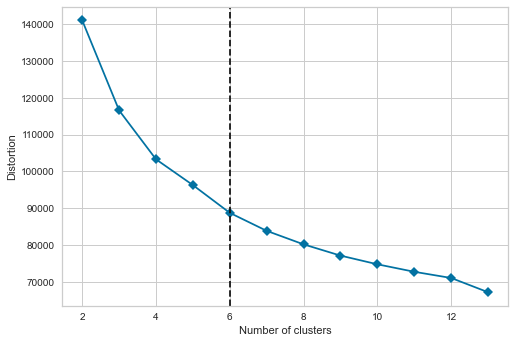

In [12]:
kmeans = KMeans(random_state = 1)
kmeans_vis = KElbowVisualizer(kmeans, k = (2, 14), metric = 'distortion', timings = 0).fit(dfT)
print('Оптимальное число кластеров:', kmeans_vis.elbow_value_)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

In [13]:
numClus = 6
km = KMeans(n_clusters = numClus, max_iter = 100, random_state = 100)
km.fit(dfT)

kmClusId = km.labels_
kmClusId = pd.DataFrame(kmClusId, index = reg_index, columns = {'id'})
kmClusId.value_counts()

id
1     27
0     23
3     20
4     17
2      9
5      6
dtype: int64

Графики стандартизованных рядов каждого кластера

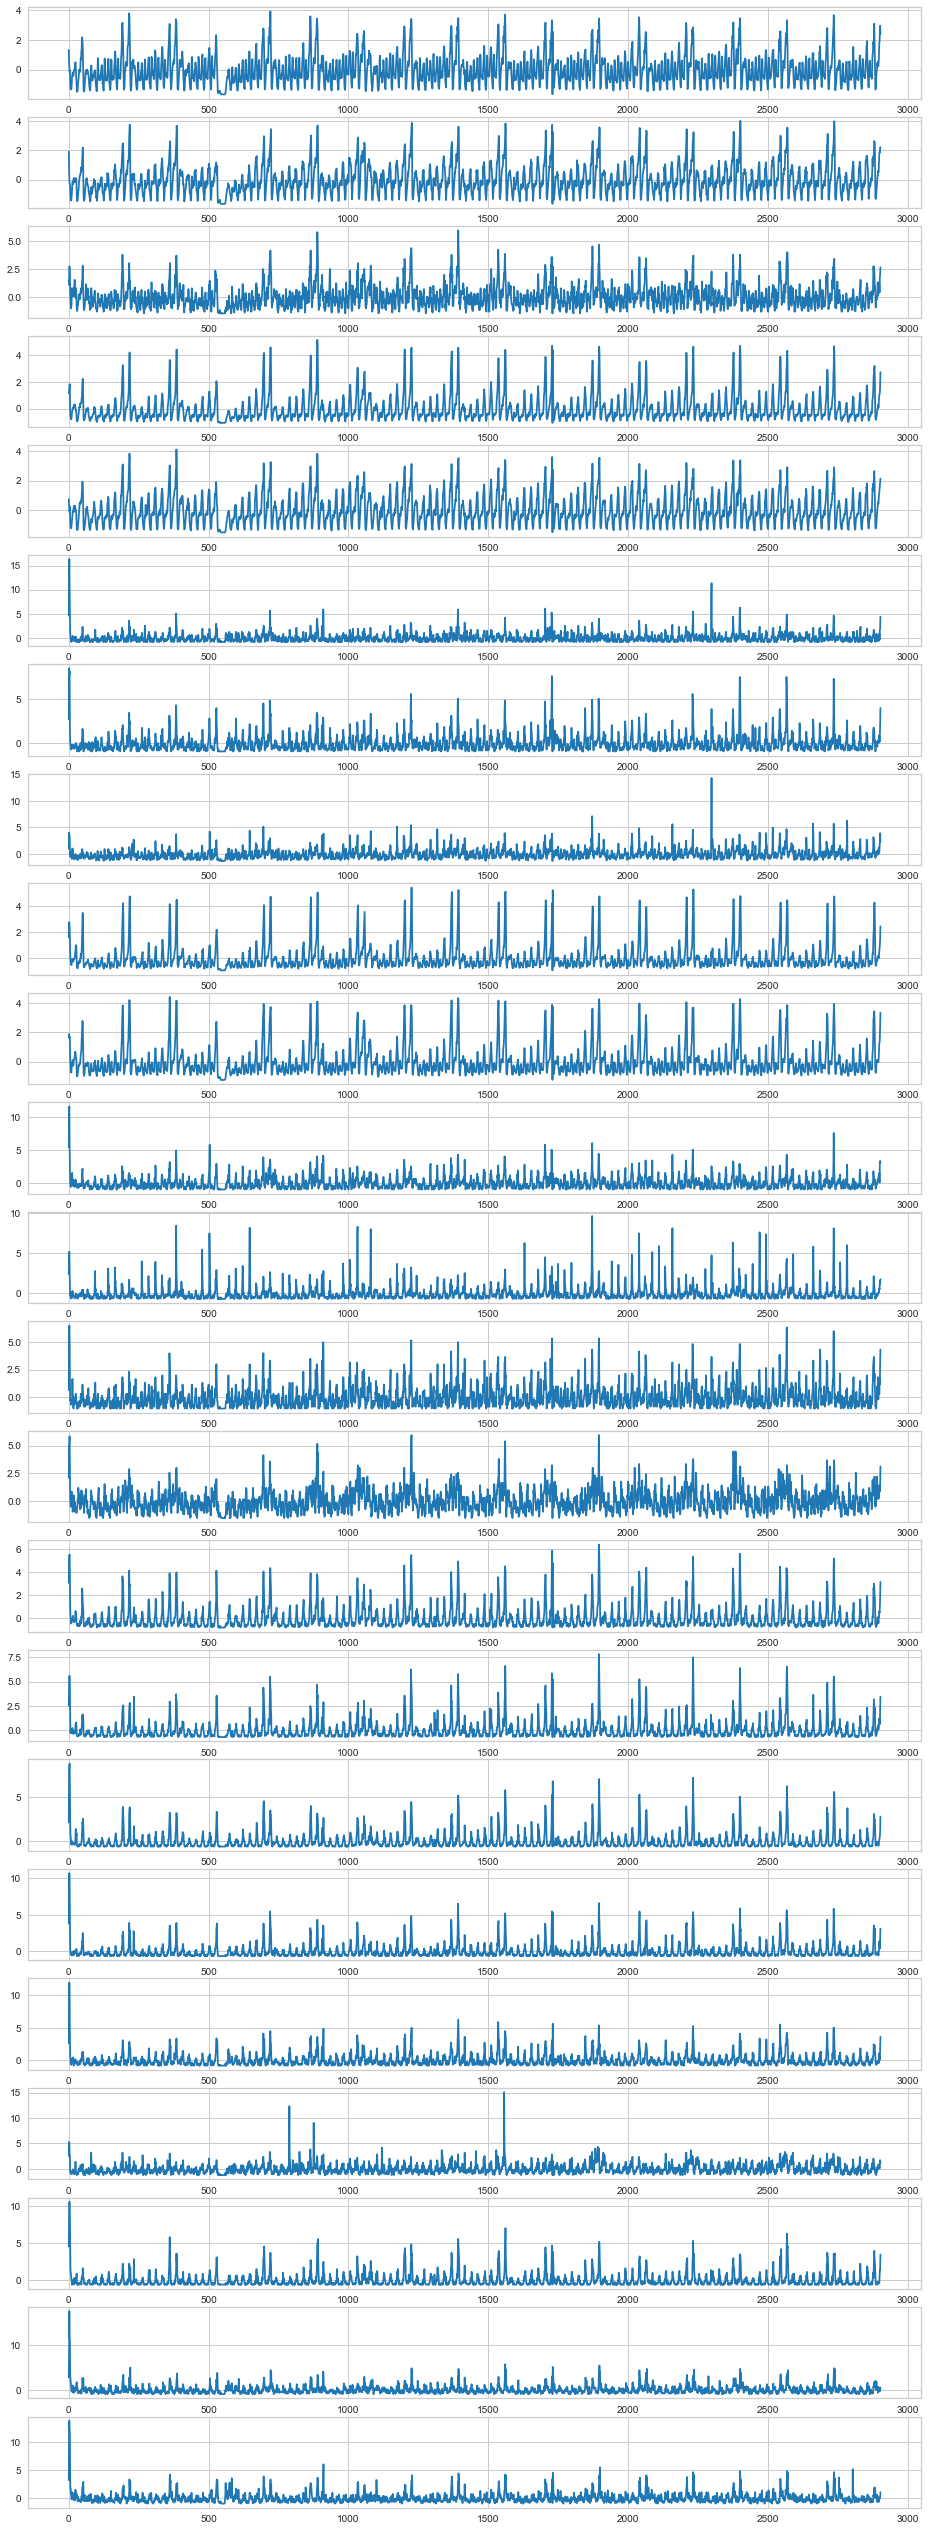

Wall time: 4.01 s


In [108]:
%%time
clust = 0
reg = kmClusId[kmClusId['id'] == clust].index
plt.figure(figsize = (16, len(reg) * 2))
for (regNum, i) in zip(reg, range(len(reg))) :
    plt.subplot(len(reg), 1, i + 1)
    plt.plot(dfS[str(regNum)], color = 'tab:blue')
plt.show()

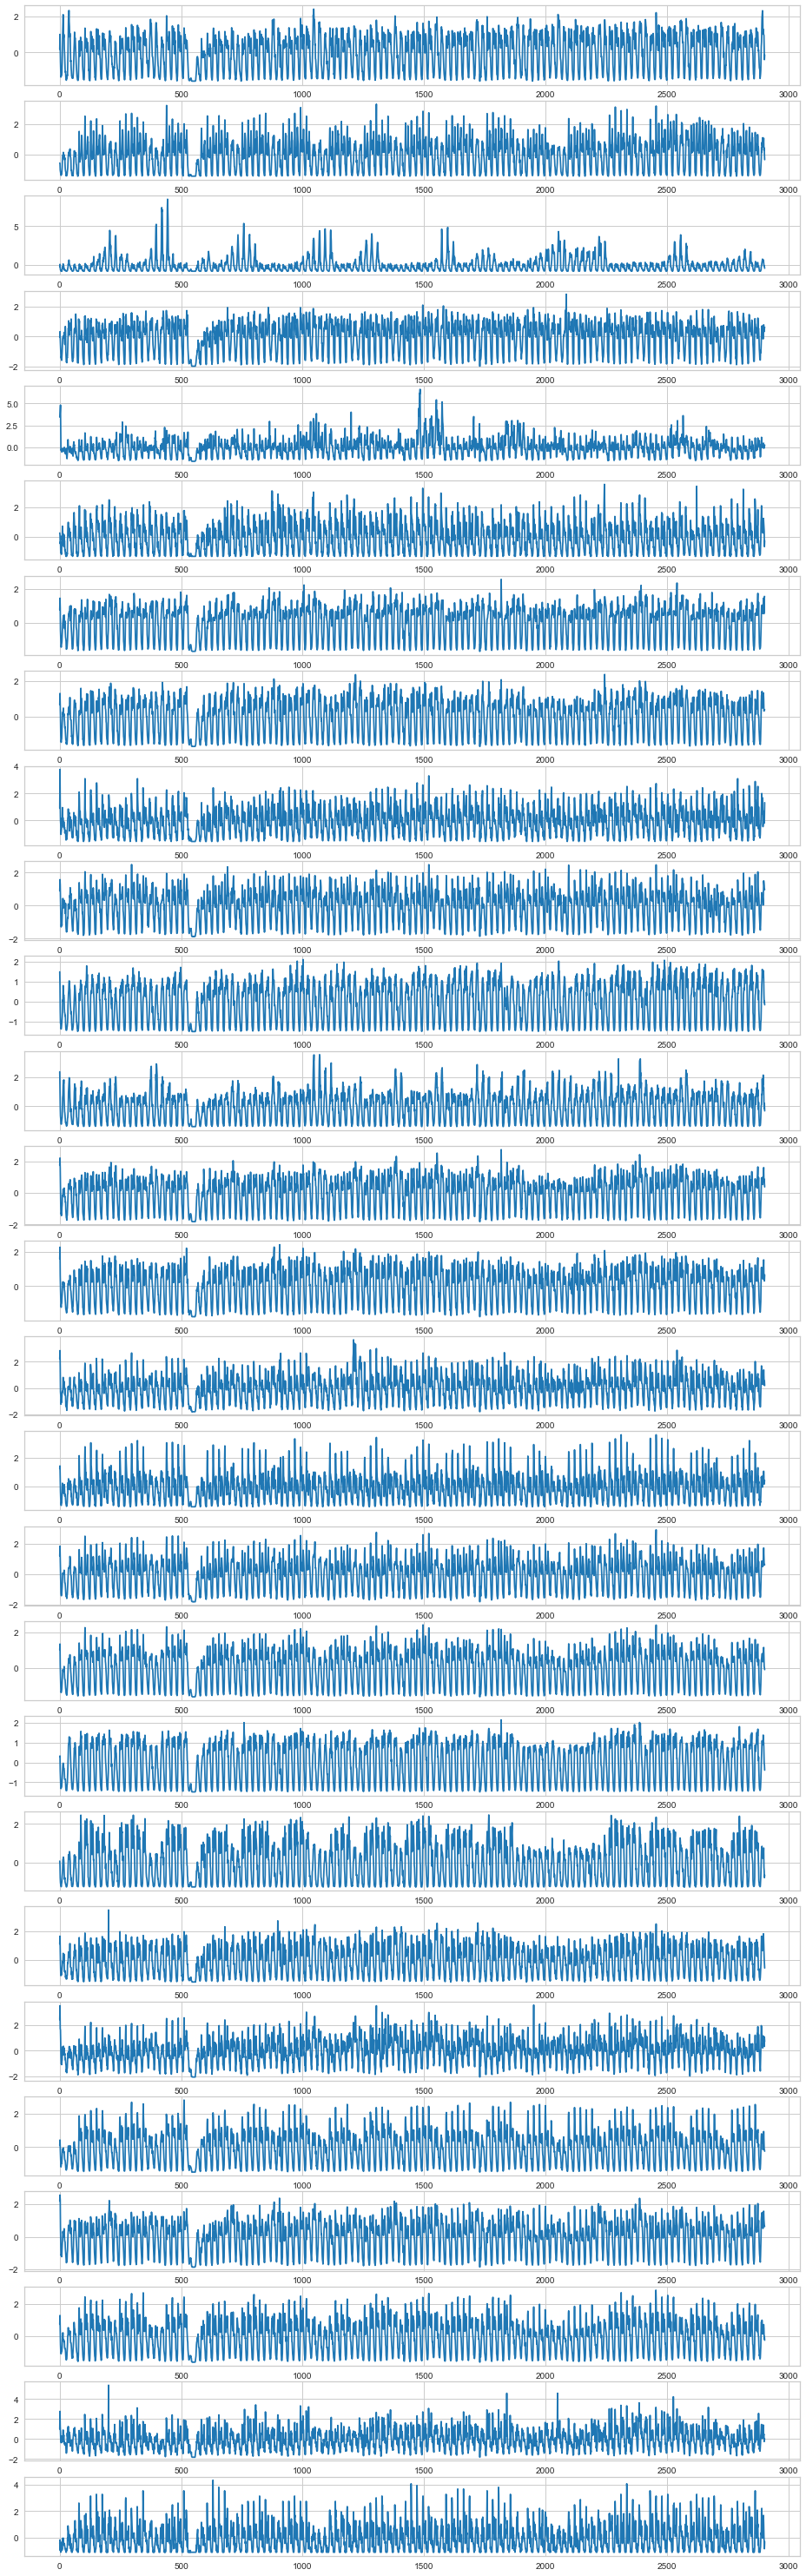

Wall time: 4.21 s


In [109]:
%%time
clust = 1
reg = kmClusId[kmClusId['id'] == clust].index
plt.figure(figsize = (16, len(reg) * 2))
for (regNum, i) in  zip(reg, range(len(reg))) :
    plt.subplot(len(reg), 1, i + 1)
    plt.plot(dfS[str(regNum)], color = 'tab:blue')
plt.show()

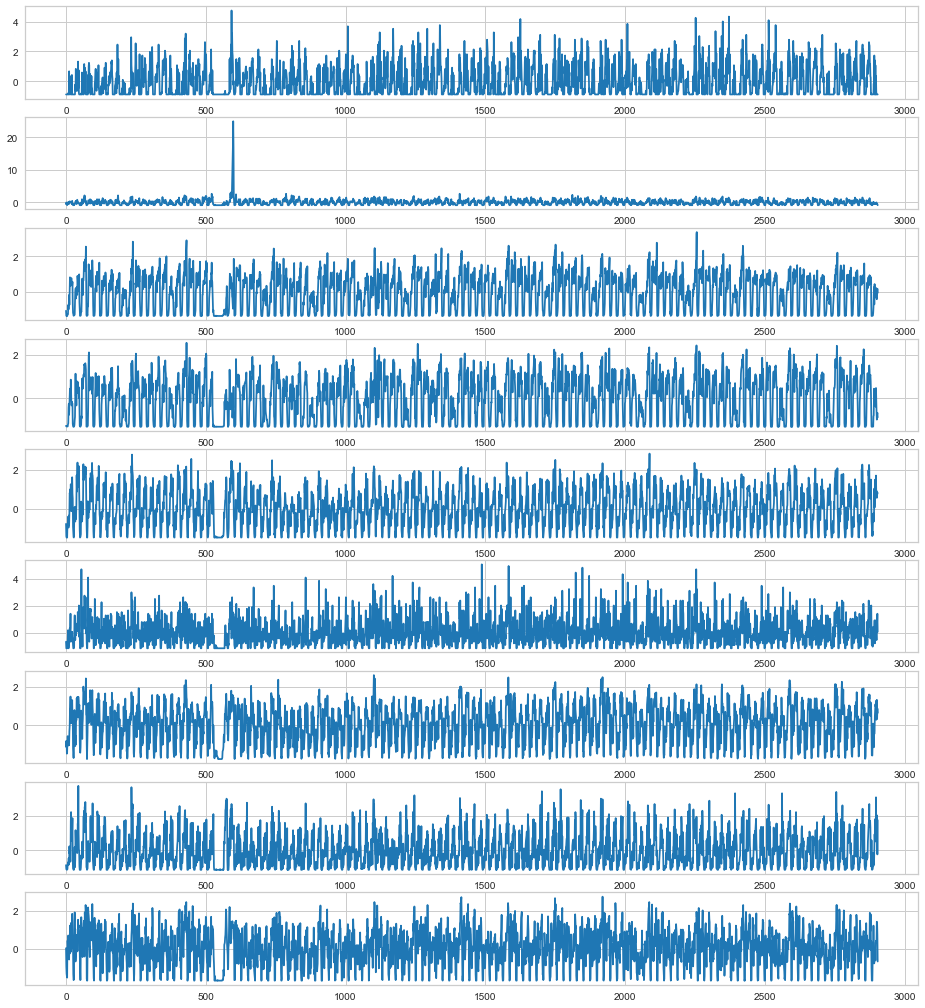

Wall time: 1.62 s


In [110]:
%%time
clust = 2
reg = kmClusId[kmClusId['id'] == clust].index
plt.figure(figsize = (16, len(reg) * 2))
for (regNum, i) in  zip(reg, range(len(reg))) :
    plt.subplot(len(reg), 1, i + 1)
    plt.plot(dfS[str(regNum)], color = 'tab:blue')
plt.show()

In [ ]:
%%time
clust = 3
reg = kmClusId[kmClusId['id'] == clust].index
plt.figure(figsize = (16, len(reg) * 2))
for (regNum, i) in  zip(reg, range(len(reg))) :
    plt.subplot(len(reg), 1, i + 1)
    plt.plot(dfS[str(regNum)], color = 'tab:blue')
plt.show()

In [ ]:
%%time
clust = 4
reg = kmClusId[kmClusId['id'] == clust].index
plt.figure(figsize = (16, len(reg) * 2))
for (regNum, i) in  zip(reg, range(len(reg))) :
    plt.subplot(len(reg), 1, i + 1)
    plt.plot(dfS[str(regNum)], color = 'tab:blue')
plt.show()

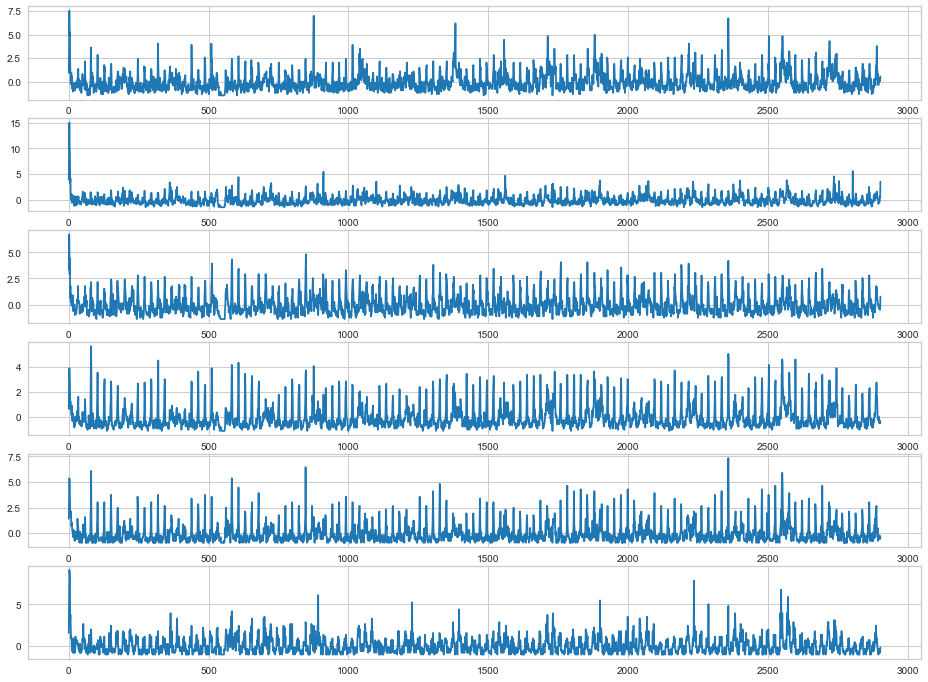

Wall time: 940 ms


In [113]:
%%time
clust = 5
reg = kmClusId[kmClusId['id'] == clust].index
plt.figure(figsize = (16, len(reg) * 2))
for (regNum, i) in  zip(reg, range(len(reg))) :
    plt.subplot(len(reg), 1, i + 1)
    plt.plot(dfS[str(regNum)], color = 'tab:blue')
plt.show()

Для каждого кластера выберем наиболее близкий к центру ряд

In [117]:
from sklearn.metrics import pairwise_distances_argmin_min

In [118]:
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, dfT)
closest

array([51, 55, 97, 71, 19, 88], dtype=int64)

In [119]:
indexes = dfT.index[closest]
indexes

Index(['1326', '1333', '2068', '1387', '1180', '1530'], dtype='object')

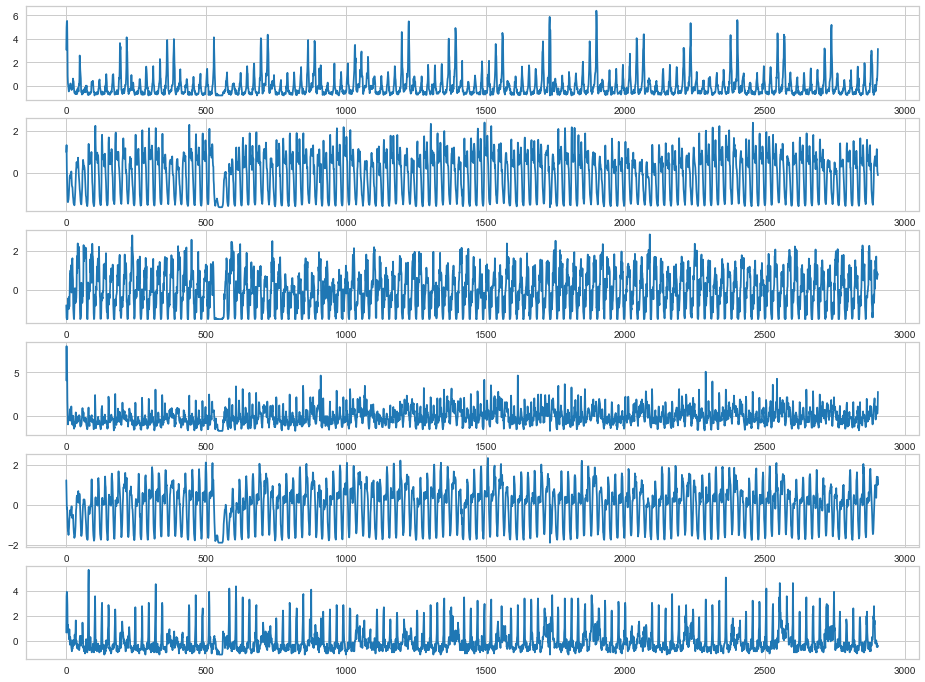

Wall time: 1.12 s


In [120]:
%%time
plt.figure(figsize = (16, 12))
for i in range(numClus) :
    plt.subplot(numClus, 1, i + 1)
    plt.plot(dfS[indexes[i]], color='tab:blue')
    
plt.show()

### Подбор начальных приближений параметров p, P, q, Q для ARIMA

In [121]:
def prepair_for_ARIMA(clust, k = 51):
    dataset = pd.DataFrame(df[indexes[clust]].values,index=df.index, columns = {'count'})
    dataset['time'] = df.index
    dataset.head()
    w = 168 # длительность недели в часах
    t = np.arange(1, dataset.shape[0] + 1)
    dataset['constant'] = np.ones(dataset.shape[0])
    for i in range(1,k):
        sin = "s" + str(i)
        cos = "c" + str(i)
        dataset[sin] = np.sin(2 * i * np.pi * t / w)
        dataset[cos] = np.cos(2 * i * np.pi * t / w)
    dataset['time'] = pd.to_datetime(dataset['time'], format = '%Y-%m-%d %H:%M:%S')
    for j in range(wheather.shape[0]):
        w ='wh_' + str(j)
        dataset[w] = 0
    for i in range(dataset.shape[0]):
        for j in range(wheather.shape[0]):
            w = 'wh_' + str(j)
            if ((dataset['time'].iloc[i].year == wheather[j].year) & (dataset['time'].iloc[i].month == wheather[j].month) & (dataset['time'].iloc[i].day== wheather[j].day)):
                dataset[w].iloc[i] = 1
    model0 = sm.OLS(dataset['count'], dataset.drop(['count','time'], axis=1)).fit()
    print(model0.rsquared_adj)
    print(model0.aic)
    
    return(dataset, model0)

def graph_analysis_for_ARIMA(model):
    resid = pd.DataFrame(model.resid, columns = {'resid'}) 
    resid['resid_D24'] = resid.resid - resid.resid.shift(24)
    sm.tsa.seasonal_decompose(resid.resid[0:1000], period=24).plot( )
    sm.tsa.seasonal_decompose(resid.resid_D24[25:1000], period=24).plot( )
    plt.figure(figsize=(16,24))
    ax1 = plt.subplot(411)
    sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=628, ax=ax1)
    ax2 = plt.subplot(412)
    sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=np.arange(0,100), ax=ax2)
    ax3 = plt.subplot(413)
    sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags=628, ax=ax3)
    ax4 = plt.subplot(414)
    sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags = np.arange(0,100), ax=ax4)
    #plt.show()
    plt.figure(figsize=(16,24))
    ax1 = plt.subplot(411)
    sm.graphics.tsa.plot_acf(resid['resid_D24'][25:].values.squeeze(), lags = 628, ax = ax1)
    ax2 = plt.subplot(412)
    sm.graphics.tsa.plot_acf(resid['resid_D24'][25:].values.squeeze(), lags = np.arange(0,100), ax = ax2)
    ax3 = plt.subplot(413)
    sm.graphics.tsa.plot_pacf(resid['resid_D24'][25:].values.squeeze(), lags = 628, ax = ax3)
    ax4 = plt.subplot(414)
    sm.graphics.tsa.plot_pacf(resid['resid_D24'][25:].values.squeeze(), lags = np.arange(0,100), ax = ax4)
    plt.show()
    print('p-value критерия Дики-Фуллера для ряда остатков =', round(adfuller(resid['resid'])[1], 4))
    print('p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  =', round(adfuller(resid['resid_D24'][24:])[1], 4))



0.8319591953670685
22202.83936574744


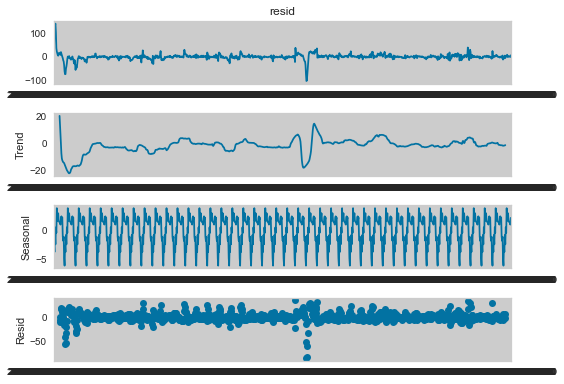

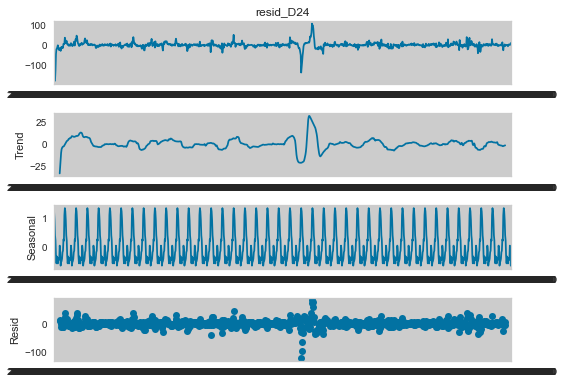

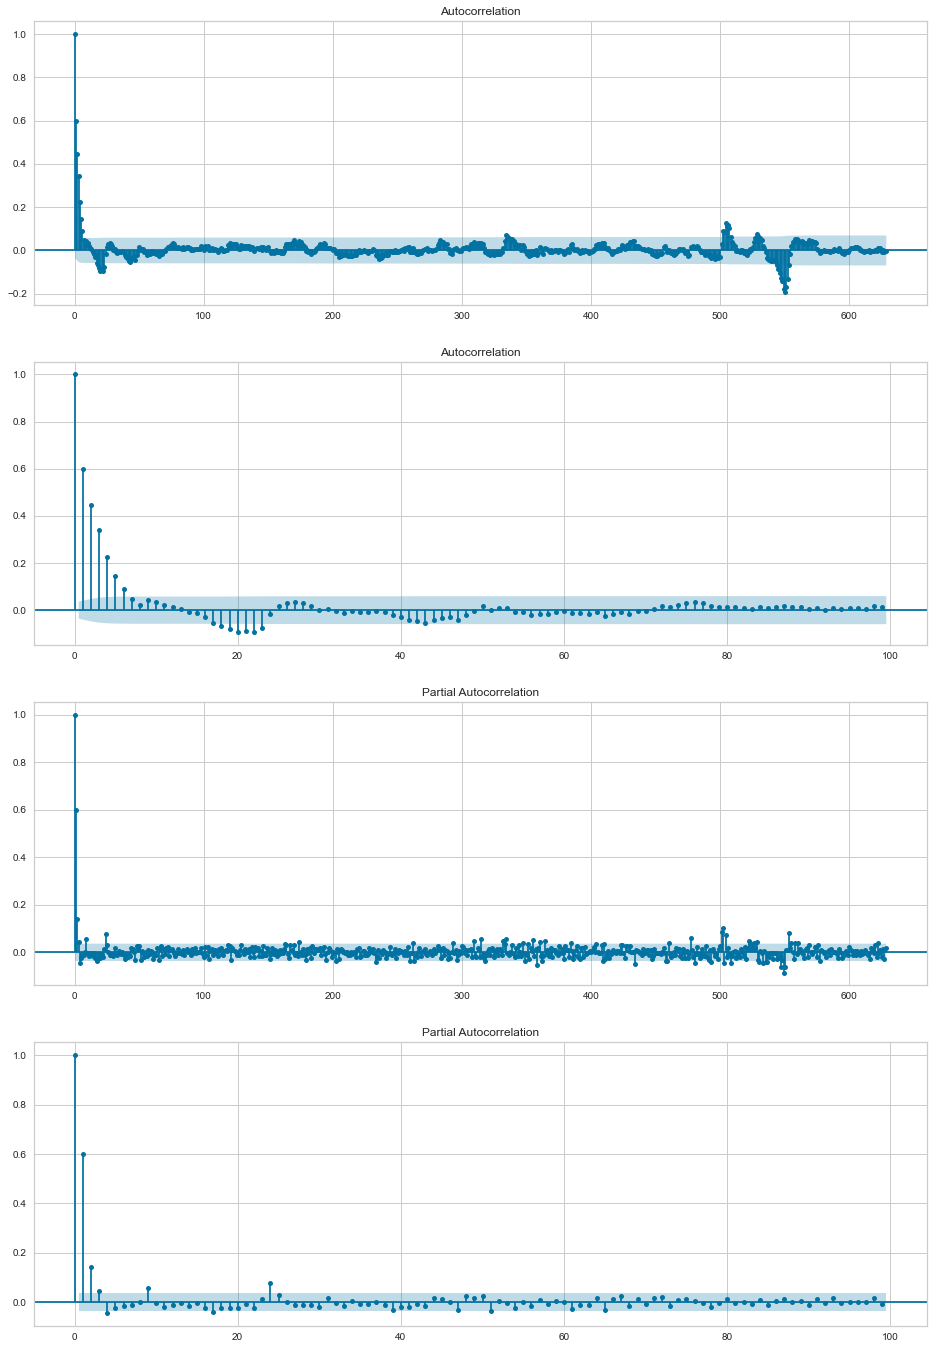

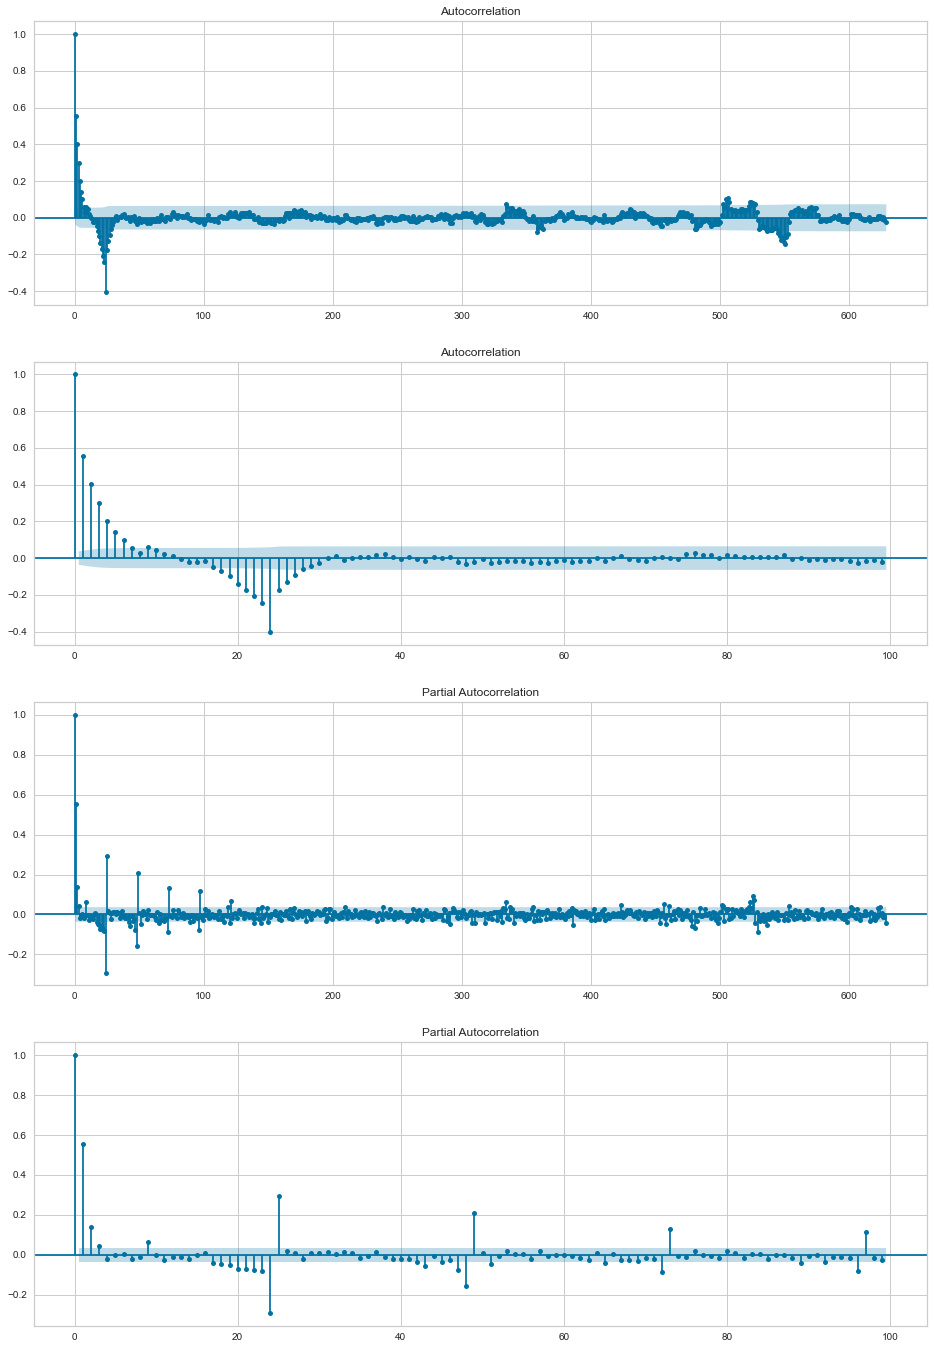

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [122]:
clust0, mod0 = prepair_for_ARIMA(0)
graph_analysis_for_ARIMA(mod0)

0.9276756378951161
33891.578640089705


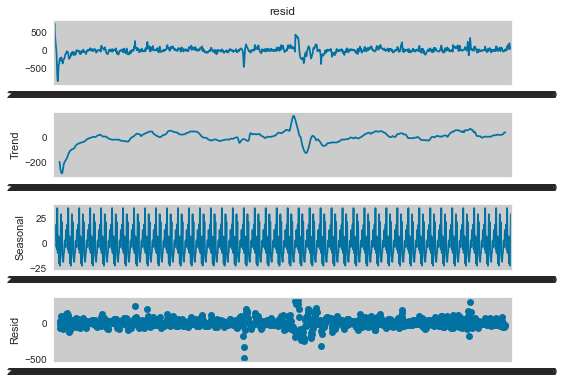

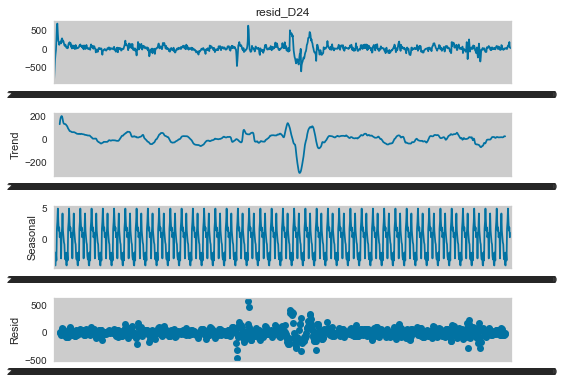

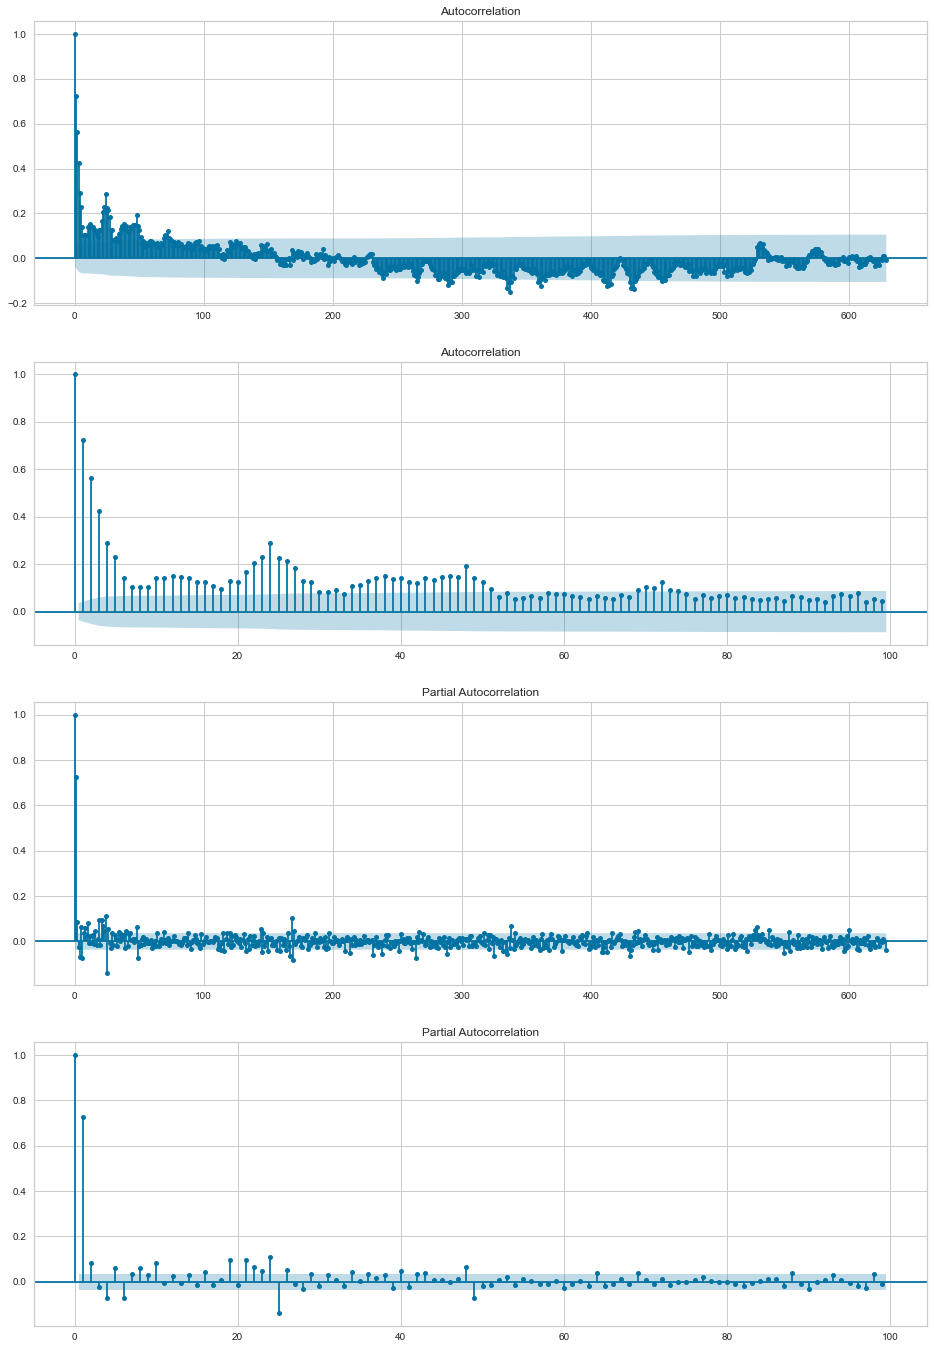

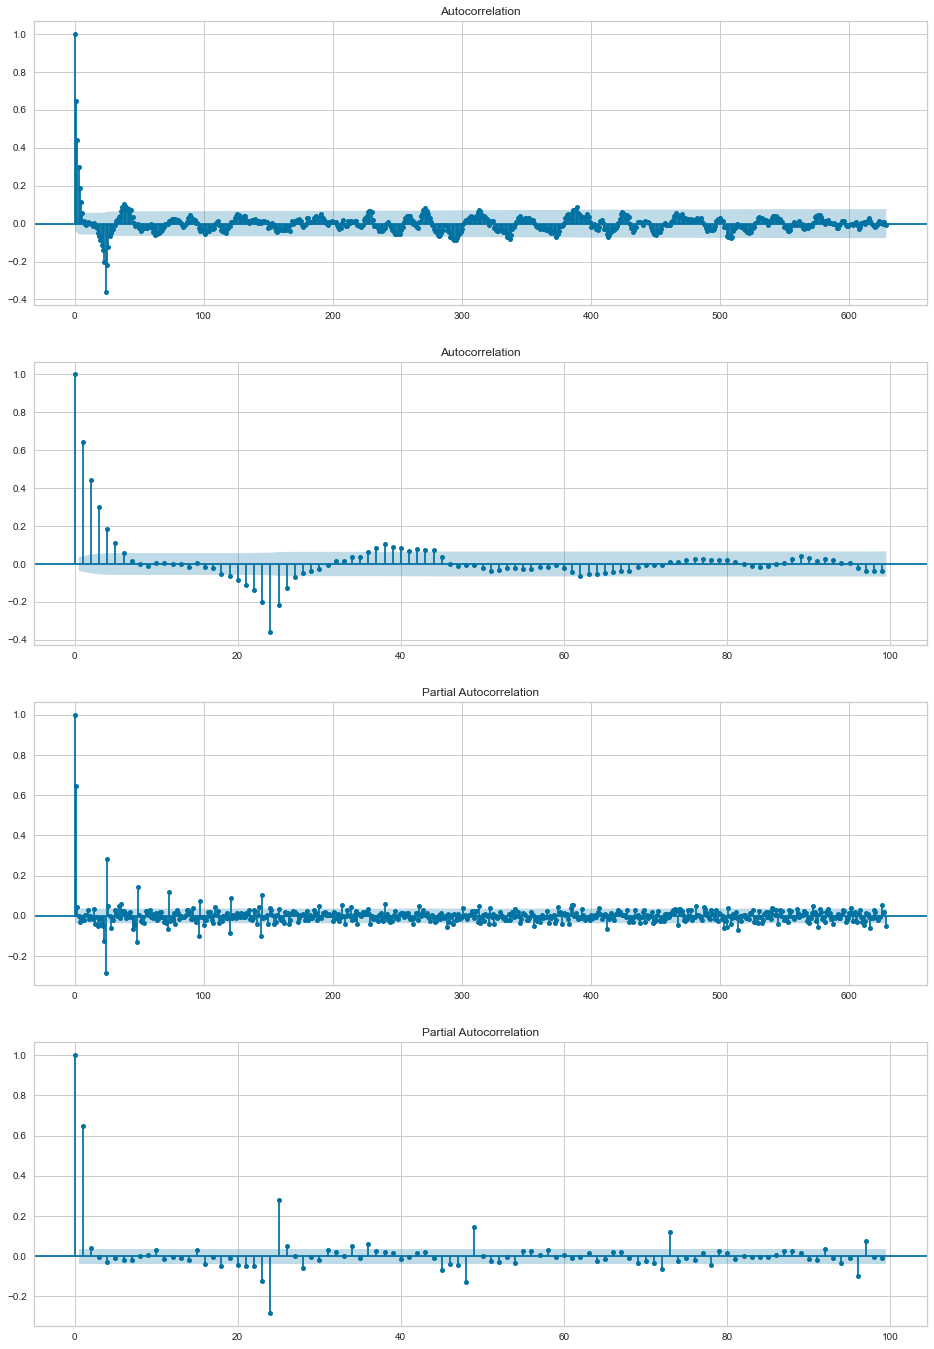

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [123]:
clust1, mod1 = prepair_for_ARIMA(1)
graph_analysis_for_ARIMA(mod1)

0.8332091760831289
26733.174435201636


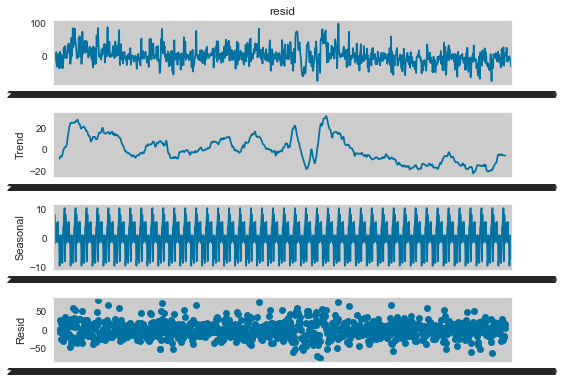

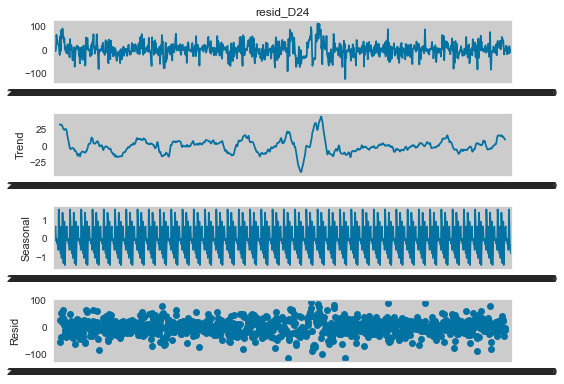

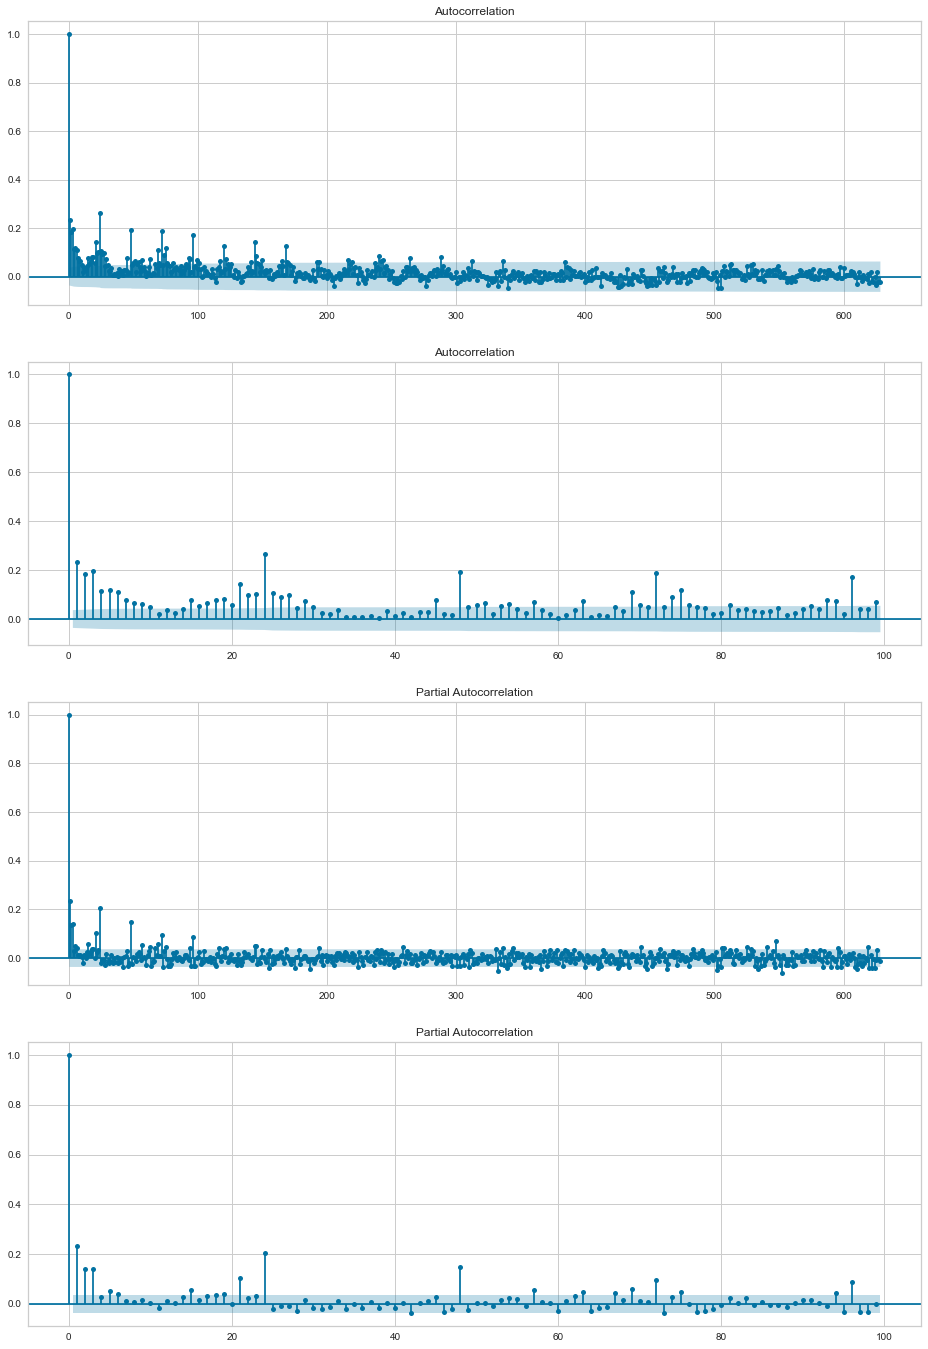

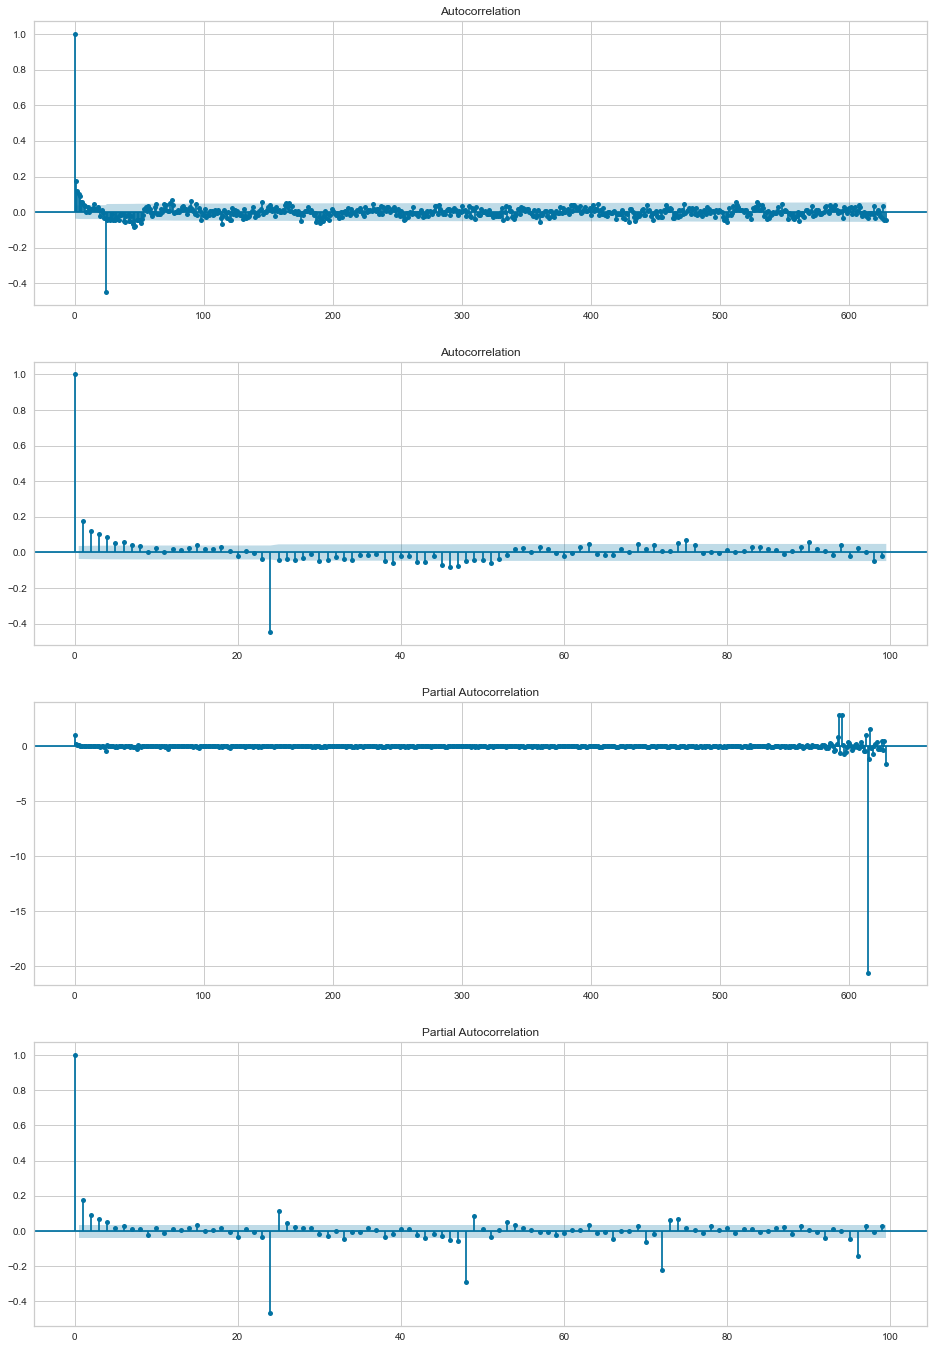

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [124]:
clust2, mod2 = prepair_for_ARIMA(2)
graph_analysis_for_ARIMA(mod2)

In [ ]:
clust3, mod3 = prepair_for_ARIMA(3)
graph_analysis_for_ARIMA(mod3)

0.9216029268930275
34030.25058779532


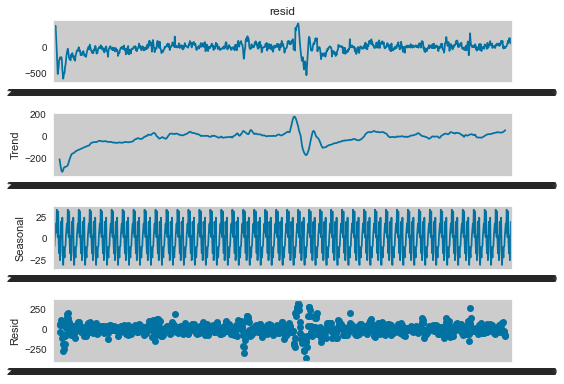

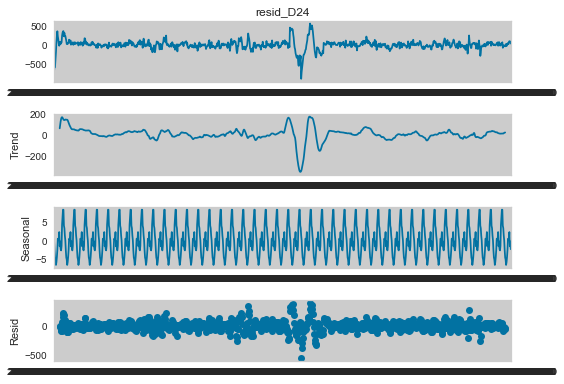

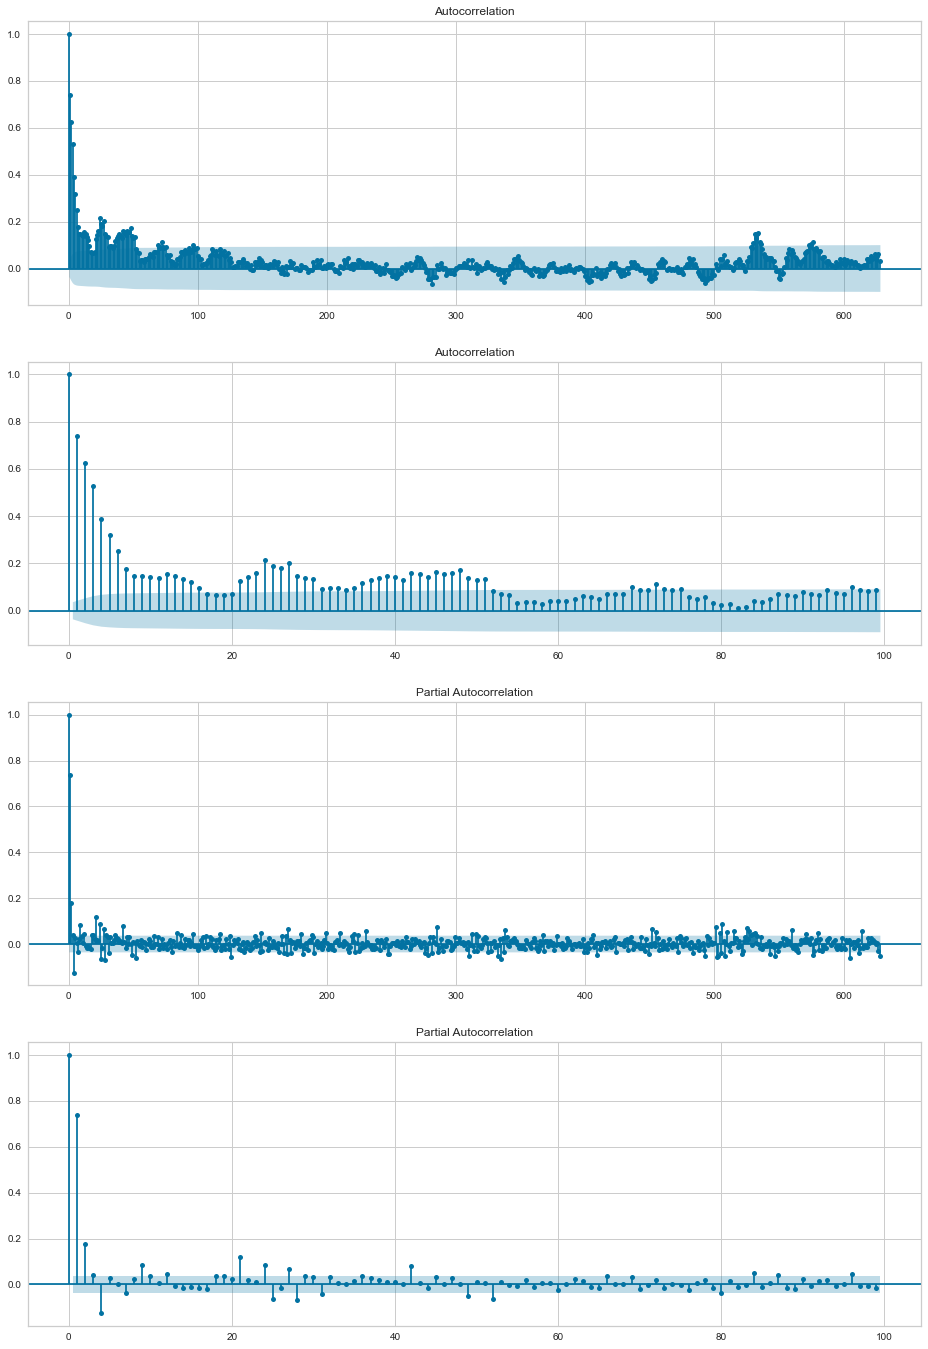

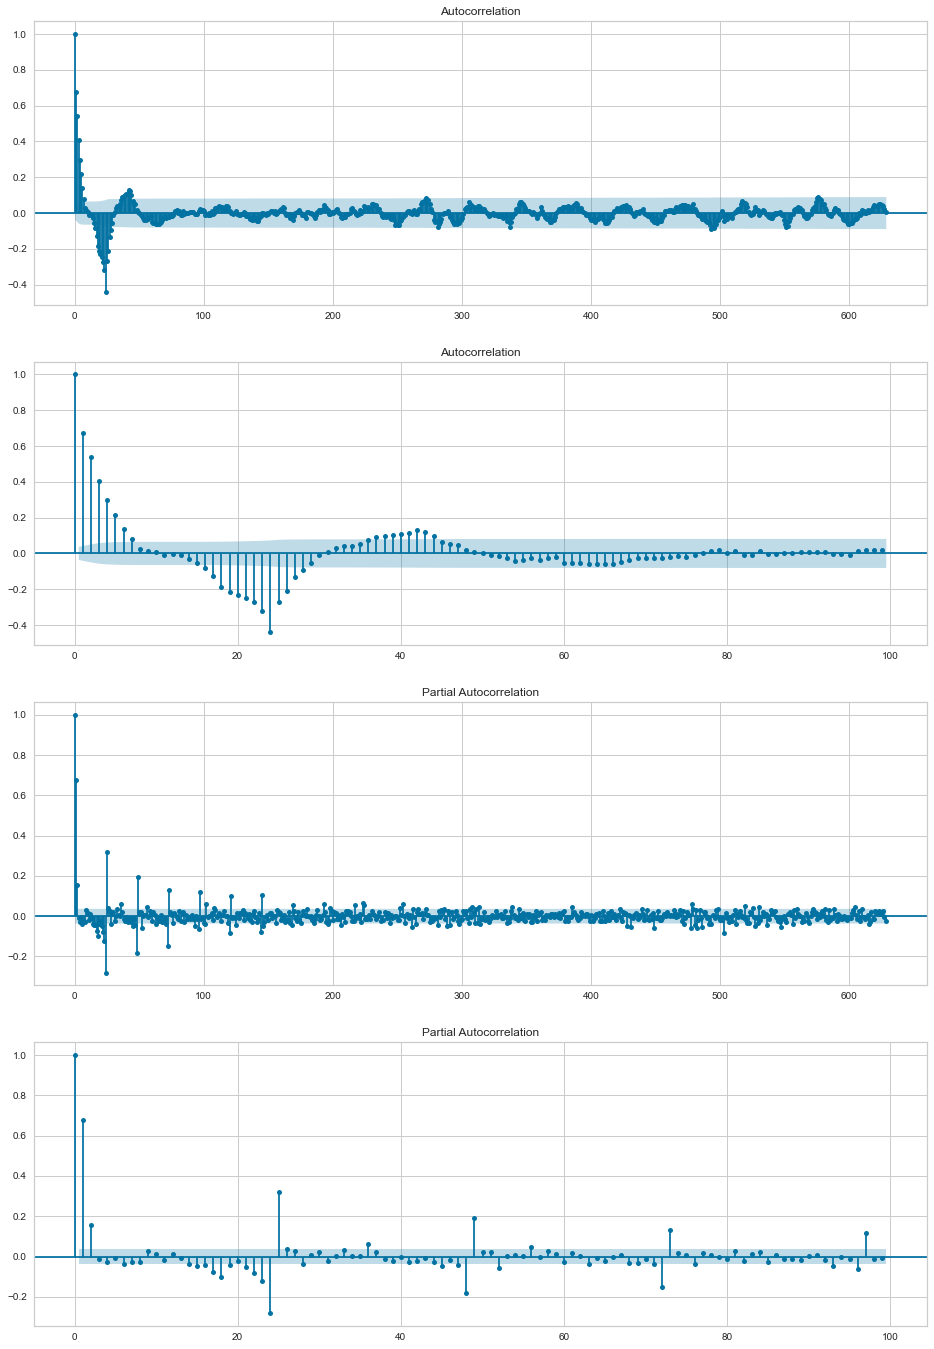

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [126]:
clust4, mod4 = prepair_for_ARIMA(4)
graph_analysis_for_ARIMA(mod4)

In [ ]:
clust5, mod5 = prepair_for_ARIMA(5)
graph_analysis_for_ARIMA(mod5)

Подбор гиперпараметров p, P, q, Q для моделей SARIMA

In [29]:
def sarimax_gridsearch(ts, exog, par, d = 0, D = 0, s = 24, maxiter = 50, freq = 'H'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''
    # Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for (comb,j) in zip(par,range(len(par))):
        print(j)
        try:
            model = sm.tsa.statespace.SARIMAX(ts, exog, order=(comb[0],d,comb[1]),
                                                seasonal_order=(comb[2],D, comb[3],s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)
            output = model.fit(maxiter=maxiter, method='nm', disp=-1)
            ans.append([comb,output.aic])
            print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns = ['pqPQ', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by = ['aic'],ascending=True)[0:10]
    
    return ans_df

In [ ]:
Q0 = range(0, 1)
q0 = range(0, 7)
P0 = range(0, 2)
p0 = range(0, 10)
s0 = 24
exogen0 = clust0.drop(['time', 'count'], axis = 1)
parameters0 = list(product(p0, q0, P0, Q0))
len(parameters0)

140

In [ ]:
%%time
sarimax_gridsearch(clust0['count'], exogen0, parameters0, freq = 'H')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
CPU times: user 44min 36s, sys: 28min 38s, total: 1h 13min 14s
Wall time: 48min 21s


pqPQ           aic
127  (9, 0, 1, 0)  20253.525022
129  (9, 1, 1, 0)  20258.184272
131  (9, 2, 1, 0)  20258.942276
133  (9, 3, 1, 0)  20260.351803
137  (9, 5, 1, 0)  20265.367395
113  (8, 0, 1, 0)  20267.947838
123  (8, 5, 1, 0)  20270.876282
125  (8, 6, 1, 0)  20271.385734
115  (8, 1, 1, 0)  20272.019436
117  (8, 2, 1, 0)  20272.546524

In [30]:
Q1 = range(0, 2)
q1 = range(0, 6)
P1 = range(0, 2)
p1 = range(0, 2)
s1 = 24
exogen1 = clust1.drop(['time', 'count'], axis = 1)
parameters1 = list(product(p1, q1, P1, Q1))
len(parameters1)

48

In [31]:
%%time
sarimax_gridsearch(clust1['count'], exogen1, parameters1, freq = 'H')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
Wall time: 14min 7s


pqPQ           aic
47  (1, 5, 1, 1)  30811.877661
43  (1, 4, 1, 1)  30821.563030
39  (1, 3, 1, 1)  30837.558279
35  (1, 2, 1, 1)  30859.928090
45  (1, 5, 0, 1)  30871.488631
31  (1, 1, 1, 1)  30875.636762
41  (1, 4, 0, 1)  30881.464204
46  (1, 5, 1, 0)  30887.808621
42  (1, 4, 1, 0)  30888.406767
38  (1, 3, 1, 0)  30891.738617

In [32]:
Q2 = range(0, 2)
q2 = range(0, 5)
P2 = range(0, 5)
p2 = range(0, 4)
s2 = 24
exogen2 = clust2.drop(['time', 'count'], axis = 1)
parameters2 = list(product(p2, q2, P2, Q2))
len(parameters2)

200

In [ ]:
%%time
sarimax_gridsearch(clust2['count'], exogen2, parameters2, freq = 'H')

In [34]:
Q3 = range(0, 2)
q3 = range(0, 4)
P3 = range(0, 4)
p3 = range(0, 3)
s3 = 24
exogen3 = clust3.drop(['time', 'count'], axis = 1)
parameters3 = list(product(p3, q3, P3, Q3))
len(parameters3)

96

In [35]:
%%time
sarimax_gridsearch(clust3['count'], exogen3, parameters3, freq = 'H')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
Wall time: 1h 56min 46s


pqPQ           aic
63  (1, 3, 3, 1)  19468.747888
87  (2, 2, 3, 1)  19470.885131
95  (2, 3, 3, 1)  19471.313961
55  (1, 2, 3, 1)  19474.340043
79  (2, 1, 3, 1)  19474.747172
47  (1, 1, 3, 1)  19475.654629
62  (1, 3, 3, 0)  19491.046834
86  (2, 2, 3, 0)  19492.828057
94  (2, 3, 3, 0)  19493.656529
78  (2, 1, 3, 0)  19496.395208

In [36]:
Q4 = range(0, 2)
q4 = range(0, 4)
P4 = range(0, 4)
p4 = range(0, 3)
s4 = 24
exogen4 = clust4.drop(['time', 'count'], axis = 1)
parameters4 = list(product(p4, q4, P4, Q4))
len(parameters4)

96

In [37]:
%%time
sarimax_gridsearch(clust4['count'], exogen4, parameters4, freq = 'H')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
Wall time: 1h 47min 9s


pqPQ           aic
95  (2, 3, 3, 1)  30554.719915
94  (2, 3, 3, 0)  30556.468075
63  (1, 3, 3, 1)  30571.003547
70  (2, 0, 3, 0)  30571.389187
71  (2, 0, 3, 1)  30572.296887
62  (1, 3, 3, 0)  30572.576333
78  (2, 1, 3, 0)  30573.942872
79  (2, 1, 3, 1)  30574.628688
86  (2, 2, 3, 0)  30577.849180
54  (1, 2, 3, 0)  30578.177342

In [38]:
Q5 = range(0, 3)
q5 = range(0, 4)
P5 = range(0, 2)
p5 = range(0, 3)
s5 = 24
exogen5 = clust5.drop(['time', 'count'], axis = 1)
parameters5 = list(product(p5, q5, P5, Q5))
len(parameters5)

72

In [39]:
%%time
sarimax_gridsearch(clust5['count'], exogen5, parameters5, freq = 'H')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
Wall time: 43min 3s


pqPQ           aic
47  (1, 3, 1, 2)  16990.479953
44  (1, 3, 0, 2)  16992.000541
71  (2, 3, 1, 2)  16993.234126
68  (2, 3, 0, 2)  16995.039830
41  (1, 2, 1, 2)  17001.240616
38  (1, 2, 0, 2)  17003.540487
35  (1, 1, 1, 2)  17007.917413
59  (2, 1, 1, 2)  17009.193575
32  (1, 1, 0, 2)  17012.021730
56  (2, 1, 0, 2)  17013.168916

## Добавление данных за май и июнь

In [14]:
df5 = pd.read_csv("taxi_05_2016.csv")
df6 = pd.read_csv("taxi_06_2016.csv")
df5.rename(columns={'Unnamed: 0':'time'}, inplace=True)
df6.rename(columns={'Unnamed: 0':'time'}, inplace=True)
df5.index = df5.time
df6.index = df6.time
df5 = df5.iloc[:,nonzero_reg]
df6 = df6.iloc[:,nonzero_reg]
dfAll=pd.concat([df, df5, df6], axis=0)
dfAll.head()

1075   1076  1077   1125   1126   1127   1128   1129  \
time                                                                        
2016-01-01 00:00:00  80.0  144.0  50.0   77.0  319.0  402.0  531.0  617.0   
2016-01-01 01:00:00  91.0  211.0  49.0  134.0  404.0  420.0  370.0  453.0   
2016-01-01 02:00:00  90.0  146.0  23.0  110.0  393.0  425.0  313.0  366.0   
2016-01-01 03:00:00  32.0   87.0  16.0   62.0  252.0  399.0  324.0  309.0   
2016-01-01 04:00:00  24.0   43.0  10.0   53.0  145.0  254.0  264.0  333.0   

                      1130   1131  ...  1630  1684  1733  1734  1783  2068  \
time                               ...                                       
2016-01-01 00:00:00  846.0  267.0  ...  12.0   0.0   2.0  44.0   5.0  41.0   
2016-01-01 01:00:00  594.0  224.0  ...  29.0   0.0   5.0   2.0   2.0   4.0   
2016-01-01 02:00:00  377.0  138.0  ...  47.0   0.0   3.0   0.0   4.0   0.0   
2016-01-01 03:00:00  327.0  166.0  ...  46.0   0.0   2.0   4.0   5.0   1.0   
2016-01-01 04:00:00  318.0  145.0  ...  43.0   0.0   0.0   1.0   1.0   0.0   

                     2069  2118  2119  2168  
time                                         
2016-01-01 00:00:00   4.0  70.0   7.0  66.0  
2016-01-01 01:00:00   0.0  47.0   1.0  29.0  
2016-01-01 02:00:00   0.0  69.0   1.0  14.0  
2016-01-01 03:00:00   0.0  21.0   0.0   9.0  
2016-01-01 04:00:00   0.0  26.0   1.0   6.0  

[5 rows x 102 columns]

In [15]:
w = 168
reg0 = kmClusId[kmClusId['id'] == 0].index
reg1 = kmClusId[kmClusId['id'] == 1].index
reg2 = kmClusId[kmClusId['id'] == 2].index
reg3 = kmClusId[kmClusId['id'] == 3].index
reg4 = kmClusId[kmClusId['id'] == 4].index
reg5 = kmClusId[kmClusId['id'] == 5].index

t = np.arange(1, dfAll.shape[0] + 1)

cluster0 = {}
cluster1 = {}
cluster2 = {}
cluster3 = {}
cluster4 = {}
cluster5 = {}


In [16]:
model0 = {}
model1 = {}
model2 = {}
model3 = {}
model4 = {}
model5 = {}

In [17]:
for regI in list(map(str, reg0)):
    cluster0[regI] = pd.DataFrame()
    cluster0[regI]['count'] = dfAll[regI]
    cluster0[regI].index = dfAll.index

for regI in list(map(str, reg1)):
    cluster1[regI] = pd.DataFrame()
    cluster1[regI]['count'] = dfAll[regI]
    cluster1[regI].index = dfAll.index

for regI in list(map(str, reg2)):
    cluster2[regI] = pd.DataFrame()
    cluster2[regI]['count'] = dfAll[regI]
    cluster2[regI].index = dfAll.index

for regI in list(map(str, reg3)):
    cluster3[regI] = pd.DataFrame()
    cluster3[regI]['count'] = dfAll[regI]
    cluster3[regI].index = dfAll.index

for regI in list(map(str, reg4)):
    cluster4[regI] = pd.DataFrame()
    cluster4[regI]['count'] = dfAll[regI]
    cluster4[regI].index = dfAll.index

for regI in list(map(str, reg5)):
    cluster5[regI] = pd.DataFrame()
    cluster5[regI]['count'] = dfAll[regI]
    cluster5[regI].index = dfAll.index

In [13]:
t = np.arange(1, dfAll.shape[0] + 1)
exogen = pd.DataFrame()
time = dfAll.index
time = pd.to_datetime(time, format = '%Y-%m-%d %H:%M:%S')
exogen['constant'] = np.ones(dfAll.shape[0])
exogen.index = dfAll.index
for i in range(1, 51):
    sin = "s" + str(i)
    cos = "c" + str(i)
    exogen[sin] = np.sin(2 * i * np.pi * t / w)
    exogen[cos] = np.cos(2 * i * np.pi * t / w)
    exogen['wheather'] = np.zeros(dfAll.shape[0])
    for j in range(dfAll.shape[0]):
        for k in range(wheather.shape[0]):
            if ((time[j].year == wheather[k].year) & (time[j].month == wheather[k].month) & (time[j].day== wheather[k].day)):
                exogen['wheather'][j] = 1
exogen

NameError: name 'dfAll' is not defined

In [28]:
import pickle

In [44]:
%%time
p = 9
q = 0
P = 1
Q = 0
d = 0
D = 0
s = 24
ind_last = 3648
for regI in list(map(str, reg0)):
    model0[regI] = sm.tsa.statespace.SARIMAX(cluster0[regI][0 :ind_last],exog=exogen.iloc[0 :ind_last], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
    model0[regI].save("./models-may/model0_" + str(regI) + ".pkl")
    print(model0[regI].aic)

37955.39234885956
39079.189724727665
23056.814019766687
38339.69188183565
39832.92655731994
17941.072926157598
20860.883272676998
24226.425165739645
35776.30744009196
38871.267720138116
20070.130500495252
26782.503645957353
18833.21525293465
21302.310279276386
25369.25760071368
26961.415674257274
23616.2126732306
20760.8858683426
19453.25292743871
20728.14380842551
18418.13847246976
19063.097293184044
20974.9995441234
Wall time: 3h 23min 28s


In [29]:
%%time
p = 1
q = 5
P = 1
Q = 1
d = 0
D = 0
s = 24
ind_last = 3648
for regI in list(map(str, reg1)):
    model1[regI] = sm.tsa.statespace.SARIMAX(cluster1[regI][0 :ind_last], exog = exogen.iloc[0 :ind_last], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
    model1[regI].save("./models-may/model1_" + str(regI) + ".pkl")
    print(model1[regI].aic)

31367.990541939278
29842.415211549443
30799.674203222567
43294.712225297764
34512.939950356915
22778.141118394204
37980.84469753231
32204.68092094308
24569.43998263468
32889.09703648789
34781.956216831255
30671.258480456414
34845.29582396703
34499.511244919726
28720.670735938373
26171.420669092164
36242.52208185738
38858.80583608105
38218.76247752903
31396.24278902539
27923.111846481224
28815.447441184555
34680.05985294325
38674.178406442545
35030.59120040685
26433.592767751943
19406.728458596823
Wall time: 3h 34min 55s


In [ ]:
%%time
p = 3
P = 4
Q = 1
q = 3
d = 0
D = 0
s = 24
ind_last=3648
for regI in list(map(str, reg2)):
    model2[regI] = sm.tsa.statespace.SARIMAX(cluster2[regI][0 :ind_last],exog=exogen.iloc[0 :ind_last], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
    model2[regI].save("./models-may/model2_" + str(regI) + ".pkl")
    print(model2[regI].aic)

In [ ]:
%%time
p = 1
P = 3
Q = 1
q = 3
d = 0
D = 0
s = 24
ind_last=3648
for regI in list(map(str, reg3)):
    model3[regI] = sm.tsa.statespace.SARIMAX(cluster3[regI][0 :ind_last],exog=exogen.iloc[0 :ind_last], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
    model3[regI].save("./models-may/model3_" + str(regI) + ".pkl")
    print(model3[regI].aic)

25090.216990479465
20062.604038113408
18744.286905059977
16927.902840107912


In [20]:
%%time
p = 2
P = 3
Q = 1
q = 3
d = 0
D = 0
s = 24
ind_last=3648
for regI in list(map(str, reg4)):
    model4[regI] = sm.tsa.statespace.SARIMAX(cluster4[regI][0 :ind_last],exog=exogen.iloc[0 :ind_last], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
    model4[regI].save("./models-may/model4_" + str(regI) + ".pkl")
    print(model4[regI].aic)

27827.50524733054
23126.155926266787
Wall time: 1h 46min 25s


In [21]:
%%time
p = 1
P = 1
Q = 2
q = 3
d = 0
D = 0
s = 24
ind_last = 3648
for regI in list(map(str, reg5)):
    model5[regI] = sm.tsa.statespace.SARIMAX(cluster5[regI][0 :ind_last],exog=exogen.iloc[0 :ind_last], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
    model5[regI].save("./model5_" + str(regI) + ".pkl")
    print(model5[regI].aic

20796.201949894603
20591.932395430747
19678.245395497328
21406.0148850829
17471.71017968937
17634.379973173207
Wall time: 2h 32min 50s


### Построение прогнозов в мае и вычисление ошибки

In [29]:
h = 2904

In [ ]:
Rsum0 = 0
for regI in list(map(str, reg0)):
    sum0 = 0
    modI = 0
    with open('./models-may/model0_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(739):
        predY = modI.get_prediction(start = h + i, end = h + i + 5, dynamic = 1, exog = exogen.iloc[h + i: h + i + 6,])
        sum0 += np.abs(dfAll.iloc[h + i: h + i + 6][regI].values - predY.predicted_mean.values).sum()
    Rsum0 += sum0
    print (sum0 / (739 * 6))

In [78]:
print('Ошибка за май для кластера 0:', Rsum0/(739 * 6*len(reg0)))

Ошибка за май для кластера 0: 11.676202369132177


In [79]:
Rsum1 = 0
for regI in list(map(str, reg1)):
    sum1 = 0
    modI = 0
    with open('./models-may/model1_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(739):
        predY = modI.get_prediction(start = h + i, end = h + i + 5, dynamic = 1, exog = exogen.iloc[h + i: h + i + 6,])
        sum1 += np.abs(dfAll.iloc[h + i: h + i + 6][regI].values - predY.predicted_mean.values).sum()
    Rsum1 += sum1
    print (sum1 / (739 * 6))

14.739283801547929
11.05952131456128
12.393131503591453
70.90975176519551
18.375514275988515
4.121187389871829
32.53223394109496
15.975219319562008
5.551353766897765
18.88733082229738
25.206142938815784
11.157289932622577
24.212355238798633
20.165282041845252
9.317697519938477
6.950498580515717
28.215577032364013
42.95723459538776
38.13367884952998
14.119300258168819
8.250878390140759
10.016049948822648
23.29683018443285
38.94972058145215
23.080130346875976
6.453618722335793
2.7610110318791325


In [80]:
print('Ошибка за май для кластера 1:', Rsum1/(739 * 6*len(reg1)))

Ошибка за май для кластера 1: 19.918067559056848


In [81]:
Rsum2 = 0
for regI in list(map(str, reg2)):
    sum2 = 0
    modI = 0
    with open('./models-may/model2_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(739):
        predY = modI.get_prediction(start = h + i, end = h + i + 5, dynamic = 1, exog = exogen.iloc[h + i: h + i + 6,])
        sum2 += np.abs(dfAll.iloc[h + i: h + i + 6][regI].values - predY.predicted_mean.values).sum()
    Rsum2 += sum2
    print (sum2 / (739 * 6 ))

5.333445902938684
2.166892197345547
29.908453947700956
34.232716618895246
16.669102433713753
4.075899912437744
21.0352180777552
10.603011404008218
14.726274643886777


In [82]:
print('Ошибка за май для кластера 2:', Rsum2/(739 * 6*len(reg2)))

Ошибка за май для кластера 2: 15.41677945985357


In [83]:
Rsum3 = 0
for regI in list(map(str, reg3)):
    sum3 = 0
    modI = 0
    with open('./models-may/model3_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(739):
        predY = modI.get_prediction(start = h + i, end = h + i + 5, dynamic = 1, exog = exogen.iloc[h + i: h + i + 6,])
        sum3 += np.abs(dfAll.iloc[h + i: h + i + 6][regI].values - predY.predicted_mean.values).sum()
    Rsum3 += sum3
    print (sum3 / (739 * 6))

2.66008388044426
5.937818758225602
5.707784156827184
3.588128641091502
38.01137824547276
5.3350111824574205
2.3214149105375603
2.728164744302512
5.663346887583968
4.735496385273886
3.507924046098405
3.8558511066104155
4.543235938416994
2.3998758967052862
5.244502335799211
6.267846745840378
2.8141523870714322
2.4256429149966445
1.9862271033917582
2.5383786069032626


In [84]:
print('Ошибка за май для кластера 3:', Rsum3/(739 * 6*len(reg3)))

Ошибка за май для кластера 3: 5.613613243702523


In [85]:
Rsum4 = 0
for regI in list(map(str, reg4)):
    sum4 = 0
    modI = 0
    with open('./models-may/model4_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(739):
        predY = modI.get_prediction(start = h + i, end = h + i + 5, dynamic = 1, exog = exogen.iloc[h + i: h + i + 6,])
        sum4 += np.abs(dfAll.iloc[h + i: h + i + 6][regI].values - predY.predicted_mean.values).sum()
    Rsum4 += sum4
    print (sum4 / (739 * 6 ))

9.690262270777307
9.32098144204262
18.60873462316769
25.80509349214934
31.382234272180156
19.650276199653653
39.89865882113557
45.04067515343544
40.05950247672027
53.65204300365267
56.83555236645975
64.54642335878263
46.611560656206535
53.80383148816151
70.07374585078044
9.866140728336745
4.549647172878388


In [86]:
print('Ошибка за май для кластера 4:', Rsum4/(739 * 6*len(reg4)))

Ошибка за май для кластера 4: 35.258550786854165


In [37]:
Rsum5 = 0
for regI in list(map(str, reg5)):
    sum5 = 0
    modI = 0
    with open('./models-may/model5_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(739):
        predY = modI.get_prediction(start = h + i, end = h + i + 5, dynamic = 1, exog = exogen.iloc[h + i: h + i + 6,])
        sum5 += np.abs(dfAll.iloc[h + i: h + i + 6][regI].values - predY.predicted_mean.values).sum()
        
    Rsum5 += sum5
    print (sum5 / (739 * 6))

2.9923476563882057
2.9289637288103325
2.652964105777712
3.3153087189538497
1.9071087190245908
1.9198832472231837


In [76]:
print('Ошибка за май для кластера 5:', Rsum5/(739 * 6*len(reg5)))

Ошибка за май для кластера 5: 2.619429362696312


In [ ]:
print('Ошибка за май для всех регионов:', (Rsum0 + Rsum1 + Rsum2 + Rsum3 + Rsum4 + Rsum5)/(739 * 6 * 102)))

### Получение прогнозов в июне и вычисление ошибки

In [91]:
forecast = pd.DataFrame(columns=['id', 'y'])

In [92]:
hEndJune = 3648
hJune = 715

In [ ]:
Rsum0 = 0
for regI in list(map(str, reg0)):
    sum0 = 0
    modI = 0
    with open('./model0_' + regI + '.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(hJune):
        predY = modI.get_prediction(start = hEndJune + i, end = hEndJune + i + 5, dynamic = 1, exog =  exogen.iloc[hEndJune + i: hEndJune + i + 6 ,])
        sum0 += np.abs(dfAll.iloc[hEndJune + i: hEndJune + i + 6 ][regI].values - predY.predicted_mean.values).sum()
        for j in range(6):
            forecast = forecast.append( {'id': regI + '_' + time[hEndJune + i].strftime('%Y-%m-%d_%#H') + '_' + str(j + 1), 'y' : predY.predicted_mean.values[j]}, ignore_index=True)
    Rsum0 += sum0
    print (sum0 / (hJune * 6))

In [ ]:
print('Ошибка за июнь для кластера 0:', Rsum0/(739 * 6*len(reg0)))

In [ ]:
Rsum1 = 0
for regI in list(map(str, reg1)):
    sum1 = 0
    modI = 0
    with open('./models-may/model1_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(hJune):
        predY = modI.get_prediction(start = hEndJune + i, end = hEndJune + i + 5, dynamic = 1, exog = exogen.iloc[hEndJune + i: hEndJune + i + 6,])
        sum1 += np.abs(dfAll.iloc[hEndJune + i: hEndJune + i + 6][regI].values - predY.predicted_mean.values).sum()
        for j in range(6):
            forecast = forecast.append( {'id': regI + '_' + time[hEndJune + i].strftime('%Y-%m-%d_%#H') + '_' + str(j + 1), 'y' : predY.predicted_mean.values[j]}, ignore_index=True)
    Rsum1 += sum1
    print (sum1 / (hJune * 6))

In [ ]:
print('Ошибка за июнь для кластера 1:', Rsum1 / (739 * 6 * len(reg1)))

In [ ]:
Rsum2 = 0
for regI in list(map(str, reg2)):
    sum2 = 0
    modI = 0
    with open('./models-may/model2_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(hJune):
        predY = modI.get_prediction(start = hEndJune + i, end = hEndJune + i + 5, dynamic = 1, exog = exogen.iloc[hEndJune + i: hEndJune + i + 6,])
        sum2 += np.abs(dfAll.iloc[hEndJune + i: hEndJune + i + 6][regI].values - predY.predicted_mean.values).sum()
        for j in range(6):
            forecast = forecast.append( {'id': regI + '_' + time[hEndJune + i].strftime('%Y-%m-%d_%#H') + '_' + str(j + 1), 'y' : predY.predicted_mean.values[j]}, ignore_index=True)
    Rsum2 += sum2
    print (sum2 / (hJune * 6))

In [ ]:
print('Ошибка за июнь для кластера 2:', Rsum2 / (739 * 6 * len(reg2)))

In [ ]:
Rsum3 = 0
for regI in list(map(str, reg3)):
    sum3 = 0
    modI = 0
    with open('./models-may/model3_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(hJune):
        print(i)
        predY = modI.get_prediction(start = hEndJune + i, end = hEndJune + i + 5, dynamic = 1, exog = exogen.iloc[hEndJune + i: hEndJune + i + 6,])
        sum3 += np.abs(dfAll.iloc[hEndJune + i: hEndJune + i + 6][regI].values - predY.predicted_mean.values).sum()
        for j in range(6):
            forecast = forecast.append( {'id': regI + '_' + time[hEndJune + i].strftime('%Y-%m-%d_%#H') + '_' + str(j + 1), 'y' : predY.predicted_mean.values[j]}, ignore_index=True)
    Rsum3 += sum3
    print (sum3 / (hJune * 6))

In [ ]:
print('Ошибка за июнь для кластера 3:', Rsum3 / (739 * 6 * len(reg3)))

In [ ]:
Rsum4 = 0
for regI in list(map(str, reg4)):
    sum4 = 0
    modI = 0
    with open('./models-may/model4_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(hJune):
        predY = modI.get_prediction(start = hEndJune + i, end = hEndJune + i + 5, dynamic = 1, exog = exogen.iloc[hEndJune + i: hEndJune + i + 6,])
        sum4 += np.abs(dfAll.iloc[hEndJune + i: hEndJune + i + 6][regI].values - predY.predicted_mean.values).sum()
        for j in range(6):
            forecast = forecast.append( {'id': regI + '_' + time[hEndJune + i].strftime('%Y-%m-%d_%#H') + '_' + str(j + 1), 'y' : predY.predicted_mean.values[j]}, ignore_index=True)
    Rsum4 += sum4
    print (sum4 / (hJune * 6))

In [ ]:
print('Ошибка за июнь для кластера 4:', Rsum4 / (739 * 6 * len(reg4)))

In [ ]:
Rsum5 = 0
for regI in list(map(str, reg5)):
    sum5 = 0
    modI = 0
    with open('./models-may/model5_'+regI+'.pkl', 'rb') as file:
        modI = pickle.load(file)
    for i in range(hJune):
        predY = modI.get_prediction(start = hEndJune + i, end = hEndJune + i + 5, dynamic = 1, exog = exogen.iloc[hEndJune + i: hEndJune + i + 6,])
        sum5 += np.abs(dfAll.iloc[hEndJune + i: hEndJune + i + 6][regI].values - predY.predicted_mean.values).sum()
        for j in range(6):
            forecast = forecast.append( {'id': regI + '_' + time[hEndJune + i].strftime('%Y-%m-%d_%#H') + '_' + str(j + 1), 'y' : predY.predicted_mean.values[j]}, ignore_index=True)
    Rsum5 += sum5
    print (sum5 / (hJune * 6))

In [ ]:
print('Ошибка за июнь для кластера 5:', Rsum5 / (739 * 6 * len(reg5)))

In [ ]:
# Сохранение прогнозов
forecast.to_csv('forecast.csv', index=False)